# pyhf

**Goal:** If I'm doing all of my plotting in matplotlib, I think it makes more sense to get limits with pyhf instead of the stats code that we used in the last iteration of the analysis.

But first, I'm going to try to compare the two packages for a *stats only limit* to make sure that I get the same result out of the two frameworks to make sure that I'm understanding all of the arguments and options.

In [1]:
lxplus=False

In [2]:
import pyhf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## $hh \rightarrow 4b$

I want to try to define my own workspace in the pyhf framework.

- Load in the data

In [3]:
import uproot
import pickle

In [4]:
sort_rw_cols = ['pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'njets']

In [5]:
def nanoToDf(filename,ttree='sig'):
    
    print(ttree)
    tree = uproot.open(filename)[ttree]
    return tree.pandas.df(["m_hh","mc_sf","ntag","kinematic_region"]+sort_rw_cols)

In [128]:
if lxplus:
    fileName = "/afs/cern.ch/user/h/hartman/Work/public/hh4b/{}_topo16_min_Rjj_h1_vec.root"
else:
    #fileName = "../../hh4b-resolved-reconstruction/{}_topo16_minMDR.root"
    fileName = "../../hh4b-resolved-reconstruction/{}_topo16_min_Rjj_h1_vec.root"

smnr   = nanoToDf(fileName.format("smnr"),ttree='fullmassplane')
data16 = nanoToDf(fileName.format("data16"),ttree='fullmassplane')

fullmassplane
fullmassplane


- Load in the 2b reweighting BDT 

In [7]:
data16.columns

Index(['m_hh', 'mc_sf', 'ntag', 'kinematic_region', 'pT_4', 'pT_2', 'eta_i',
       'dRjj_1', 'dRjj_2', 'njets'],
      dtype='object')

In [129]:
BDT_fname = "myBDTs/BDT_d24_16_rel21_vec_min_dRjj_h1_vec.p"
#BDT_fname = "myBDTs/BDT_d24_16_rel21_min_dRjj_h1.p"
reweighter = pickle.load(open( BDT_fname, "rb" ))

# Need to also include the 2b -> 4b factor derived from the sideband
N4bTo2b = np.sum((data16.ntag>=4) & (data16.kinematic_region==2)) / np.sum((data16.ntag==2) & (data16.kinematic_region==2))

data16['w_2b'] = N4bTo2b * reweighter.predict_weights(data16[sort_rw_cols])

In [113]:
1/N4bTo2b

181.23101058961956

- Fill numpy arrays with histograms

In [130]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

sm_hh,_ = np.histogram(smnr.loc[(smnr.ntag >= 4)&(smnr.kinematic_region==0),'m_hh'], edges,
                       weights=smnr.loc[(smnr.ntag >= 4)&(smnr.kinematic_region==0),'mc_sf'])
qcd_hh,_ = np.histogram(data16.loc[(data16.ntag == 2)&(data16.kinematic_region==0),'m_hh'], edges, 
                        weights=data16.loc[(data16.ntag == 2)&(data16.kinematic_region==0),'w_2b'])

- Define the pdf

For a limit we use the signal and background histograms to do a shape analysis, but I was getting error messages when I tried to plug in these signal and background histograms into pyhf (I wasn't sure if this was because of the bins didn't have any entries), so instead I decided to start off with just off with a single bin experiment.

**Sean's #s**

In [131]:
pdf = pyhf.simplemodels.hepdata_like(signal_data=[50.7], 
                                     bkg_data=[1020], 
                                     bkg_uncerts=[np.sqrt(1020)])

CLs_obs, CLs_exp = pyhf.utils.hypotest(1.0, [np.sqrt(1020)] + pdf.config.auxdata, pdf, return_expected=True)

print(CLs_obs, CLs_exp)

[0.] [0.11822004]


In [132]:
CLs_obs, CLs_exp_band = pyhf.utils.hypotest(1.0, [np.sqrt(1020)] + pdf.config.auxdata, pdf, return_expected_set=True)
print('Observed CL_s: io{}\n'.format(CLs_obs))
for p_value, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected CL_s{}: {}'.format('      ' if n_sigma==0 else '({:15f} σ)'.format(n_sigma),CLs_exp_band[p_value]))

Observed CL_s: io[0.]

Expected CL_s(      -2.000000 σ): [0.00807987]
Expected CL_s(      -1.000000 σ): [0.03277071]
Expected CL_s      : [0.11822004]
Expected CL_s(       1.000000 σ): [0.34107271]
Expected CL_s(       2.000000 σ): [0.68478114]


In [133]:
from pyhf import Model, optimizer

In [134]:
def plot_results(ax, test_mus, cls_obs, cls_exp, test_size=0.05):
    ax.plot(mu_tests, cls_obs, c = 'k')
    for i,c in zip(range(5),['k','k','k','k','k']):
        ax.plot(mu_tests, cls_exp[i], c = c, linestyle = 'dotted' if i!=2 else 'dashed')
    ax.fill_between(test_mus,cls_exp[0],cls_exp[-1], facecolor = 'y')
    ax.fill_between(test_mus,cls_exp[1],cls_exp[-2], facecolor = 'g')
    ax.plot(test_mus,[test_size]*len(test_mus), c = 'r')
    ax.set_ylim(0,1)

def invert_interval(test_mus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        y_vals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size, list(reversed(y_vals)), list(reversed(test_mus))))
    y_vals = cls_obs
    point05cross['obs'] = np.interp(test_size, list(reversed(y_vals)), list(reversed(test_mus)))
    return point05cross

And with the full histograms

In [135]:
np.sum(sm_hh)

3.407149854077523

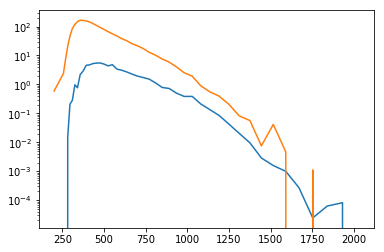

In [136]:
x = 0.5*(edges[:-1] + edges[1:])
plt.semilogy(x,20*sm_hh)
plt.semilogy(x,qcd_hh)
plt.show()

In [137]:
def simple(signal_data,bkg_data,batch_size=None):
    spec = {
        'channels':[
            {
                'name': 'singlechannel',
                'samples' : [
                    {
                        'name': 'signal',
                        'data': signal_data,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],   
                    },
                    {
                        'name': 'background',
                        'data':bkg_data,
                        'modifiers':[  
                        ],
                    },  
                ],
            }
        ]
    }
    return pyhf.Model(spec, batch_size=batch_size)

In [138]:
m = simple(list(sm_hh), list(qcd_hh))

In [147]:
mu_tests = np.linspace(1,40, 40)

hypo_tests = [pyhf.utils.hypotest(mu, m.expected_data([0]), m, 0.5, [(0,40)],
                                  return_expected_set=True, return_test_statistics=True,
                                  qtilde=True)
              for mu in mu_tests]

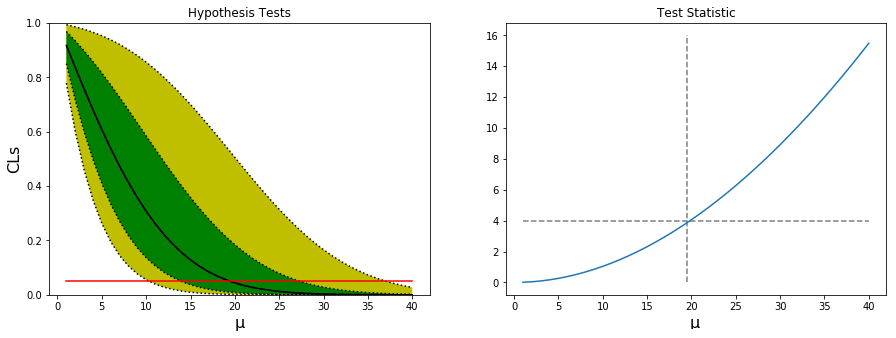

In [148]:
test_stats = np.array([test[-1][0] for test in hypo_tests]).flatten()
cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title(u'Hypothesis Tests')
ax1.set_ylabel(u'CLs',fontsize=16)
ax1.set_xlabel(u'µ',fontsize=16)
plot_results(ax1, mu_tests, cls_obs, cls_exp)

ax2.set_title(u'Test Statistic')
ax2.set_xlabel(u'µ',fontsize=16)
ax2.plot(mu_tests,4*np.ones_like(mu_tests),'grey',linestyle='--')

ax2.plot(2*[19.461],[0,16],'grey',linestyle='--')

ax2.plot(mu_tests,test_stats);

In [149]:
results = invert_interval(mu_tests, cls_obs, cls_exp)

print('Observed Limit: {:.3f}'.format(results['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.3f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results['exp'][i]))

Observed Limit: 19.461
-----
Expected Limit(-2 σ): 10.343
Expected Limit(-1 σ): 13.915
Expected Limit: 19.461
Expected Limit(1 σ): 27.326
Expected Limit(2 σ): 37.035


In [ ]:
100*(19.461-19.4511)/19.4511

In [142]:
100*(19.461-19.4511)/19.4511

0.05089686444467533

**Why we use the $CL_s$ method**

Rodger Blanford has some statstics lectures where he explained to us why we used the $CL_s$ method instead of the pure frequentist method typically for HEP analysis, so I just wanted to reproduce one of his figures with some slightly different numbers.

In [143]:
from scipy.special import factorial

In [144]:
nb = 8

a = np.linspace(0,15).reshape(-1,1)

Nd = 3
nis = np.arange(Nd+1).reshape(1,-1)

CLsb = np.sum( np.exp(-a)*np.power(a,nis) / factorial(nis) ,axis=-1)
CLb = np.sum( np.exp(-nb)*np.power(nb,nis) / factorial(nis)) * np.ones_like(CLsb)

CLs = CLsb / CLb

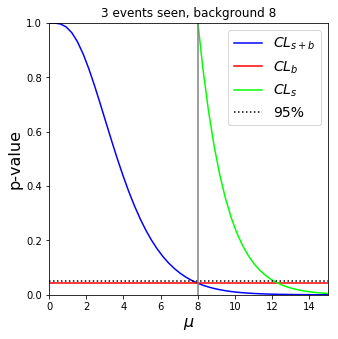

In [145]:
plt.figure(figsize=(5,5))

plt.plot(a,CLsb,'b',label="$CL_{s+b}$")
plt.plot(a,CLb,'r',label="$CL_{b}$")
plt.plot(a,CLs,'lime',label="$CL_{s}$")

plt.plot(a,0.05*np.ones_like(a),'k',linestyle=':',label="95%")

plt.plot([nb]*2,[0,1],'grey')

plt.xlim(a[0],a[-1])
plt.ylim(0,1)


plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel('p-value',fontsize=16)
plt.title('3 events seen, background {}'.format(nb))
plt.legend(fontsize=14)

plt.savefig('figures/stats/Pois_nb_{}_nd_{}.pdf'.format(nb,Nd))

plt.show()

In [146]:
i = np.argmin(np.abs(CLs-0.05))
a[i]-nb

array([4.24489796])